<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S7_Cifar/S7_Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [0]:
from __future__ import print_function
import torch
# Import core module
import torch.nn as nn
# We need support for functional programming
import torch.nn.functional as F
import torch.optim as optim
# For MNIST dataset
from torchvision import datasets, transforms
# For Global Average Pooling
from torch.nn import AvgPool2d
# Plotting purpose
%matplotlib inline
import matplotlib.pyplot as plt
# Import Torch Vision
import torchvision
# Import math library! The Numpy
import numpy as np

# Dataset Loading and Initializing the trasnforms

## Create a tranform function which is required further for the train and test loader


In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=10, shear = 10),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Dataset download to the environment

In [3]:
train = datasets.CIFAR10(root = './data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Dataloaders
We have downloaded the dataset and defined some function for the image transforms (which includes the image augmentation as well). 

Below steps ensure that we use GPU for our training and testing (Basically we want the data to be in the GPU for getting best performance) 

In [4]:
# Do we have CUDA drivers for us?
cuda = torch.cuda.is_available()
print ("Cuda Available?", cuda)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

Cuda Available? True


## Number of classes
I am not sure if is specific to CIFAR-10. Lets see afterwards

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Data visualization

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images <Enable below instructions if data visualization required>
# imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# The Convolutional Neural Network Model 

## The skeleton of the network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv01 = nn.Conv2d(3, 16, 3, bias=False, padding=1)        
        self.batch01 = nn.BatchNorm2d(num_features=16)    

        # ---- Lets take a skip connection
        self.skip_conv1 = nn.Conv2d(16, 16, 3, padding=0, dilation=2)
        
        self.conv02 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        
        self.batch02 = nn.BatchNorm2d(num_features=16)    
        self.conv03 = nn.Conv2d(16, 16, 3, bias=False,padding=1)       
        self.batch03 = nn.BatchNorm2d(num_features=16)   
        self.conv04 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        
        self.batch04 = nn.BatchNorm2d(num_features=16)   
        self.pool01 = nn.MaxPool2d(2, 2)                                #O=16
        self.conv05 = nn.Conv2d(16, 16, 1, bias=False)
        
        self.conv11 = nn.Conv2d(16, 32, 3, bias=False, padding=1)       
        self.batch11 = nn.BatchNorm2d(num_features=32)
        self.conv12 = nn.Conv2d(32, 32, 3, bias=False, padding=1)      
        self.batch12 = nn.BatchNorm2d(num_features=32)
        self.conv13 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       
        self.batch13 = nn.BatchNorm2d(num_features=32)
        self.conv14 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       
        self.batch14 = nn.BatchNorm2d(num_features=32)
        self.pool11 = nn.MaxPool2d(2, 2)                                #O=8
        self.conv15 = nn.Conv2d(32, 32, 1, bias=False)

        self.conv21 = nn.Conv2d(32, 64, 3, bias=False, padding=1)       
        self.batch21 = nn.BatchNorm2d(num_features=64)
        self.conv22 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       
        self.batch22 = nn.BatchNorm2d(num_features=64)
        self.conv23 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       
        self.batch23 = nn.BatchNorm2d(num_features=64)
        self.conv24 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       
        self.batch24 = nn.BatchNorm2d(num_features=64)
        self.pool21 = nn.MaxPool2d(2, 2)                                #O=4
        self.conv25 = nn.Conv2d(64, 64, 1, bias=False)

        self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, groups=64, bias = False, padding = 1)
        self.convPV1= nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, bias = False, padding = 0)       
        self.batch31 = nn.BatchNorm2d(num_features=128)
        self.conv32 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, groups=128, bias = False, padding = 1)
        self.convPV2= nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, bias = False, padding = 0)       
        self.batch32 = nn.BatchNorm2d(num_features=256)

       
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.convx3 = nn.Conv2d(256, 10, 1, bias=False, padding=0)

    def forward(self, x):
        x = self.batch01(F.relu(self.conv01(x)))

        # ---- Lets take a skip connection
        skip_channels = self.skip_conv1(self.skip_conv1(self.skip_conv1(self.skip_conv1(x))))

        x = self.batch02(F.relu(self.conv02(x)))
        x = self.batch03(F.relu(self.conv03(x)))
        x = self.batch04(F.relu(self.conv04(x)))
        x = self.pool01(x)
        x = self.conv05(x)
        # ----------------------------------------------------------
        
        # ---- Lets add the skip connection here
        x = skip_channels + x

        x = self.batch11(F.relu(self.conv11(x)))
        x = self.batch12(F.relu(self.conv12(x)))
        x = self.batch13(F.relu(self.conv13(x)))
        x = self.batch14(F.relu(self.conv14(x)))
        x = self.pool11(x)
        x = self.conv15(x)
        # ----------------------------------------------------------

        x = self.batch21(F.relu(self.conv21(x)))
        x = self.batch22(F.relu(self.conv22(x)))
        x = self.batch23(F.relu(self.conv23(x)))
        x = self.batch24(F.relu(self.conv24(x)))
        x = self.pool21(x)
        x = self.conv25(x)
        # ----------------------------------------------------------

        x = self.batch31(F.relu(self.convPV1(F.relu(self.conv31(x)))))
        x = self.batch32(F.relu(self.convPV2(F.relu(self.conv32(x)))))


        x = self.avg_pool(x)
        x = self.convx3(x)
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

## Display model summary

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
            Conv2d-4           [-1, 16, 24, 24]           2,320
            Conv2d-5           [-1, 16, 20, 20]           2,320
            Conv2d-6           [-1, 16, 16, 16]           2,320
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
            Conv2d-9           [-1, 16, 32, 32]           2,304
      BatchNorm2d-10           [-1, 16, 32, 32]              32
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

## Setup Train and Test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate (pbar):
    data, target = data.to(device), target.to(device)

    #Don't want history of gradients 
    optimizer.zero_grad()

    y_predict = model(data)

    # Caluclate loss
    loss = F.nll_loss(y_predict, target)
    train_losses.append(loss)

    # Back propogate error
    loss.backward()

    # Take a optimzer step
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_predict.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test (model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

## Setup Optimizers

In [0]:
model =  Net().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [11]:
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.4456359148025513 Batch_id=97 Accuracy=34.76: 100%|██████████| 98/98 [00:15<00:00,  6.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4565, Accuracy: 4769/10000 (47.69%)

EPOCH: 1


Loss=1.2803080081939697 Batch_id=97 Accuracy=53.81: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3106, Accuracy: 5371/10000 (53.71%)

EPOCH: 2


Loss=1.0501935482025146 Batch_id=97 Accuracy=60.39: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0797, Accuracy: 6124/10000 (61.24%)

EPOCH: 3


Loss=0.9879357218742371 Batch_id=97 Accuracy=65.37: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9524, Accuracy: 6607/10000 (66.07%)

EPOCH: 4


Loss=0.8769888877868652 Batch_id=97 Accuracy=68.39: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8398, Accuracy: 7016/10000 (70.16%)

EPOCH: 5


Loss=0.7898920178413391 Batch_id=97 Accuracy=71.28: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8383, Accuracy: 7077/10000 (70.77%)

EPOCH: 6


Loss=0.8020628690719604 Batch_id=97 Accuracy=73.45: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7749, Accuracy: 7250/10000 (72.50%)

EPOCH: 7


Loss=0.6259720921516418 Batch_id=97 Accuracy=75.65: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7958, Accuracy: 7262/10000 (72.62%)

EPOCH: 8


Loss=0.765417754650116 Batch_id=97 Accuracy=76.71: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7529, Accuracy: 7417/10000 (74.17%)

EPOCH: 9


Loss=0.5989164113998413 Batch_id=97 Accuracy=78.15: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6650, Accuracy: 7692/10000 (76.92%)

EPOCH: 10


Loss=0.5218091011047363 Batch_id=97 Accuracy=79.37: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6736, Accuracy: 7721/10000 (77.21%)

EPOCH: 11


Loss=0.5181688666343689 Batch_id=97 Accuracy=80.18: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6420, Accuracy: 7809/10000 (78.09%)

EPOCH: 12


Loss=0.5622618198394775 Batch_id=97 Accuracy=81.18: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6910, Accuracy: 7688/10000 (76.88%)

EPOCH: 13


Loss=0.49800315499305725 Batch_id=97 Accuracy=81.86: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6833, Accuracy: 7675/10000 (76.75%)

EPOCH: 14


Loss=0.48436468839645386 Batch_id=97 Accuracy=82.69: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6293, Accuracy: 7881/10000 (78.81%)

EPOCH: 15


Loss=0.49930667877197266 Batch_id=97 Accuracy=83.40: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6122, Accuracy: 7879/10000 (78.79%)

EPOCH: 16


Loss=0.49454689025878906 Batch_id=97 Accuracy=84.03: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6779, Accuracy: 7768/10000 (77.68%)

EPOCH: 17


Loss=0.5063462853431702 Batch_id=97 Accuracy=84.09: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6488, Accuracy: 7825/10000 (78.25%)

EPOCH: 18


Loss=0.38421666622161865 Batch_id=97 Accuracy=84.77: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6236, Accuracy: 7903/10000 (79.03%)

EPOCH: 19


Loss=0.41134268045425415 Batch_id=97 Accuracy=85.41: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.6031, Accuracy: 8006/10000 (80.06%)



# Plots

Text(0.5, 1.0, 'Test Accuracy')

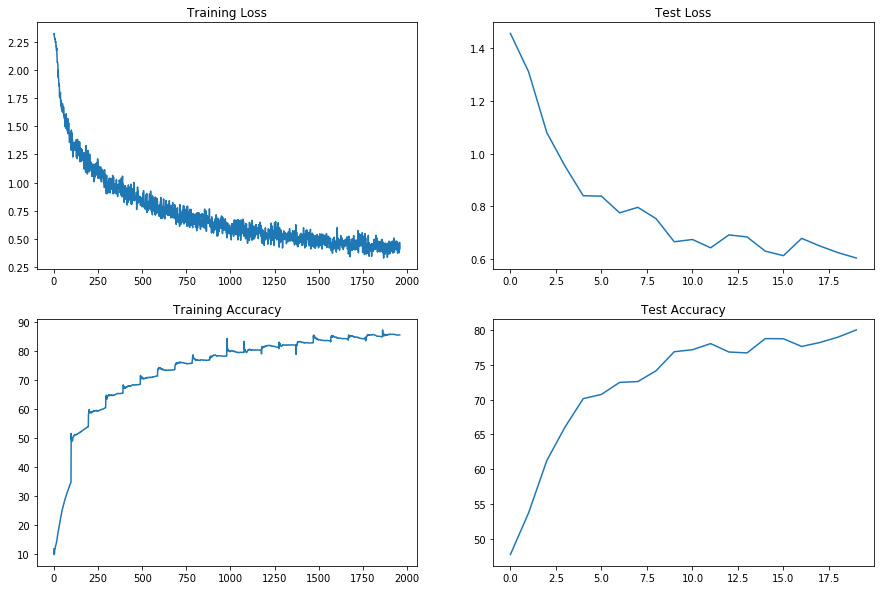

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")